In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine , text
import numpy as np
import json

# Database configuration
db_config = json.load(open('config.json'))

# SQLAlchemy connection string
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"

# Query to fetch data
query = """
SELECT 
    P.article_number,
    P.category,
    P.department,
    P.description,
    DC.d0_inventory,
    DC.d1_inventory,
    DC.d2_inventory,
    DC.d3_inventory,
    DC.d4_inventory,
    DC.d5_inventory,
    DC.d6_inventory
FROM 
    public.dailycheckin DC
JOIN 
    public.products P
ON 
    P.id = DC.product_id
ORDER BY 
    P.article_number, DC.year, DC.week;
"""

# Product Vectorization Model
class ProductVectorizationModel(nn.Module):
    def __init__(self, num_products, num_categories, num_departments, embed_dim=8, vector_dim=16):
        super().__init__()
        # Embedding layers
        self.product_embedding = nn.Embedding(num_products, embed_dim)
        self.category_embedding = nn.Embedding(num_categories, embed_dim)
        self.department_embedding = nn.Embedding(num_departments, embed_dim)
        
        # Fully connected layers for vectorization
        self.fc1 = nn.Linear(embed_dim * 3 + 7, 64)  # Embeddings + 7 inventory features
        self.fc2 = nn.Linear(64, vector_dim)  # Output: Latent vector representation

    def forward(self, inventory_features, product_ids, category_ids, department_ids):
        # Embedding lookups
        product_emb = self.product_embedding(product_ids)
        category_emb = self.category_embedding(category_ids)
        department_emb = self.department_embedding(department_ids)
        
        # Combine embeddings and features
        combined = torch.cat((inventory_features, product_emb, category_emb, department_emb), dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(combined))
        latent_vector = self.fc2(x)  # Output latent vector
        return latent_vector

# Data Preparation
def fetch_data():
    engine = create_engine(connection_string)
    df = pd.read_sql(query, engine)
    return df

def clean_and_prepare_data(df):
    # Convert inventory columns to numeric
    inventory_cols = ['d0_inventory', 'd1_inventory', 'd2_inventory', 
                      'd3_inventory', 'd4_inventory', 'd5_inventory', 
                      'd6_inventory']
    df[inventory_cols] = df[inventory_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

    # Create mappings
    product_mapping = {prod: idx for idx, prod in enumerate(df['article_number'].unique())}
    category_mapping = {cat: idx for idx, cat in enumerate(df['category'].unique())}
    department_mapping = {dept: idx for idx, dept in enumerate(df['department'].unique())}
    
    # Map categorical columns
    df['product_id'] = df['article_number'].map(product_mapping)
    df['category_id'] = df['category'].map(category_mapping)
    df['department_id'] = df['department'].map(department_mapping)
    
    # Prepare tensors
    inventory_features = torch.tensor(df[inventory_cols].values, dtype=torch.float)
    product_ids = torch.tensor(df['product_id'].values, dtype=torch.long)
    category_ids = torch.tensor(df['category_id'].values, dtype=torch.long)
    department_ids = torch.tensor(df['department_id'].values, dtype=torch.long)

    return inventory_features, product_ids, category_ids, department_ids, \
           len(product_mapping), len(category_mapping), len(department_mapping)

def compute_product_ranking_from_model(model, df, product_mapping, category_mapping, department_mapping):
    """
    Computes rankings for products based on their vector magnitudes using the trained model.

    Parameters:
    - model: Trained ProductVectorizationModel (already in memory)
    - df: DataFrame containing product and inventory data
    - product_mapping, category_mapping, department_mapping: Mappings used during training

    Returns:
    - ranked_df: DataFrame with products ranked by their vector magnitude
    """
    # Prepare data
    inventory_cols = ['d0_inventory', 'd1_inventory', 'd2_inventory', 
                      'd3_inventory', 'd4_inventory', 'd5_inventory', 
                      'd6_inventory']
    df[inventory_cols] = df[inventory_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Map categorical data
    df['product_id'] = df['article_number'].map(product_mapping)
    df['category_id'] = df['category'].map(category_mapping)
    df['department_id'] = df['department'].map(department_mapping)

    # Prepare tensors
    inventory_features = torch.tensor(df[inventory_cols].values, dtype=torch.float)
    product_ids = torch.tensor(df['product_id'].values, dtype=torch.long)
    category_ids = torch.tensor(df['category_id'].values, dtype=torch.long)
    department_ids = torch.tensor(df['department_id'].values, dtype=torch.long)

    # Normalize inventory features
    inventory_features = (inventory_features - inventory_features.mean(dim=0)) / (inventory_features.std(dim=0) + 1e-8)

    # Generate latent vectors
    model.eval()
    with torch.no_grad():
        latent_vectors = model(inventory_features, product_ids, category_ids, department_ids)
        vector_norms = latent_vectors.norm(dim=1).numpy()  # Compute magnitudes

    # Add vector norms to the DataFrame
    df['vector_magnitude'] = vector_norms

    # Compute rankings
    ranked_df = df[['article_number', 'category', 'department', 'vector_magnitude','description']].copy()
    ranked_df = ranked_df.groupby('description')['vector_magnitude'].mean().reset_index()
    ranked_df = ranked_df.sort_values(by='vector_magnitude', ascending=False).reset_index(drop=True)

    return ranked_df

# Example usage
def main_with_ranking():
    print("Fetching data...")
    df = fetch_data()  # Use the fetch_data function defined earlier

    print("Cleaning and preparing data...")
    inventory_features, product_ids, category_ids, department_ids, num_products, num_categories, num_departments = clean_and_prepare_data(df)

    # Train the model
    print("Training the model...")
    model = ProductVectorizationModel(num_products, num_categories, num_departments)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 10
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        latent_vectors = model(inventory_features, product_ids, category_ids, department_ids)
        loss = criterion(latent_vectors.norm(dim=1), torch.ones_like(latent_vectors.norm(dim=1)))
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

    # Compute rankings
    print("Computing rankings...")
    product_mapping = {prod: idx for idx, prod in enumerate(df['article_number'].unique())}
    category_mapping = {cat: idx for idx, cat in enumerate(df['category'].unique())}
    department_mapping = {dept: idx for idx, dept in enumerate(df['department'].unique())}
    ranked_df = compute_product_ranking_from_model(model, df, product_mapping, category_mapping, department_mapping)

    print("Top 10 Strong Sellers:")
    print(ranked_df.head(10))

    print("Bottom 10 Weak Sellers:")
    print(ranked_df.tail(10))

if __name__ == "__main__":
    main_with_ranking()



Fetching data...
Cleaning and preparing data...
Training the model...
Epoch 1/10, Loss: 1.7066785097122192
Epoch 2/10, Loss: 1.3836443424224854
Epoch 3/10, Loss: 1.110265851020813
Epoch 4/10, Loss: 0.8815601468086243
Epoch 5/10, Loss: 0.6926703453063965
Epoch 6/10, Loss: 0.5389379262924194
Epoch 7/10, Loss: 0.41578373312950134
Epoch 8/10, Loss: 0.3187243640422821
Epoch 9/10, Loss: 0.2434992492198944
Epoch 10/10, Loss: 0.1862432211637497
Computing rankings...
Top 10 Strong Sellers:
                     description  vector_magnitude
0  BRITANNIA TREAT WAFERS STWBRY          1.725335
1         IAMS PRH CT IND WT HRB          1.718407
2       QUALITY WHOLE WHEAT ATTA          1.707232
3      AHA BLUEBERRY POMEGRANATE          1.637330
4   RB SUMMER CRUBA ELDRFLWR 4PK          1.630629
5  LA GRILLE VEGETABLE SEASONING          1.630282
6      BOUNTY 6=12 SELECT A SIZE          1.623022
7    PATAKS CURRY PASTE VINDALOO          1.596454
8      FCY FEAST VP POULTRY PLSR          1.581071
9   

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import torch

def visualize_product_vectors(model, df, product_mapping, category_mapping, department_mapping):
    """
    Visualizes product vectors using t-SNE and matplotlib.
    
    Parameters:
    - model: Trained ProductVectorizationModel
    - df: DataFrame containing product and inventory data
    - product_mapping, category_mapping, department_mapping: Mappings used during training
    """
    # Prepare data
    inventory_cols = ['d0_inventory', 'd1_inventory', 'd2_inventory', 
                      'd3_inventory', 'd4_inventory', 'd5_inventory', 
                      'd6_inventory']
    df[inventory_cols] = df[inventory_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Map categorical data
    df['product_id'] = df['article_number'].map(product_mapping)
    df['category_id'] = df['category'].map(category_mapping)
    df['department_id'] = df['department'].map(department_mapping)

    # Prepare tensors
    inventory_features = torch.tensor(df[inventory_cols].values, dtype=torch.float)
    product_ids = torch.tensor(df['product_id'].values, dtype=torch.long)
    category_ids = torch.tensor(df['category_id'].values, dtype=torch.long)
    department_ids = torch.tensor(df['department_id'].values, dtype=torch.long)

    # Normalize inventory features
    inventory_features = (inventory_features - inventory_features.mean(dim=0)) / (inventory_features.std(dim=0) + 1e-8)

    # Generate latent vectors
    model.eval()
    with torch.no_grad():
        latent_vectors = model(inventory_features, product_ids, category_ids, department_ids).numpy()

    # Reduce dimensionality with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_vectors = tsne.fit_transform(latent_vectors)

    # Create a scatter plot
    plt.figure(figsize=(12, 8))
    unique_categories = df['category_id'].unique()
    for category_id in unique_categories:
        indices = df['category_id'] == category_id
        plt.scatter(
            reduced_vectors[indices, 0], reduced_vectors[indices, 1],
            label=f"Category {category_id}",
            alpha=0.6
        )

    # Add plot details
    plt.title("Product Vectorization Visualization (t-SNE)", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend(title="Categories", fontsize=10)
    plt.grid(True)
    plt.show()


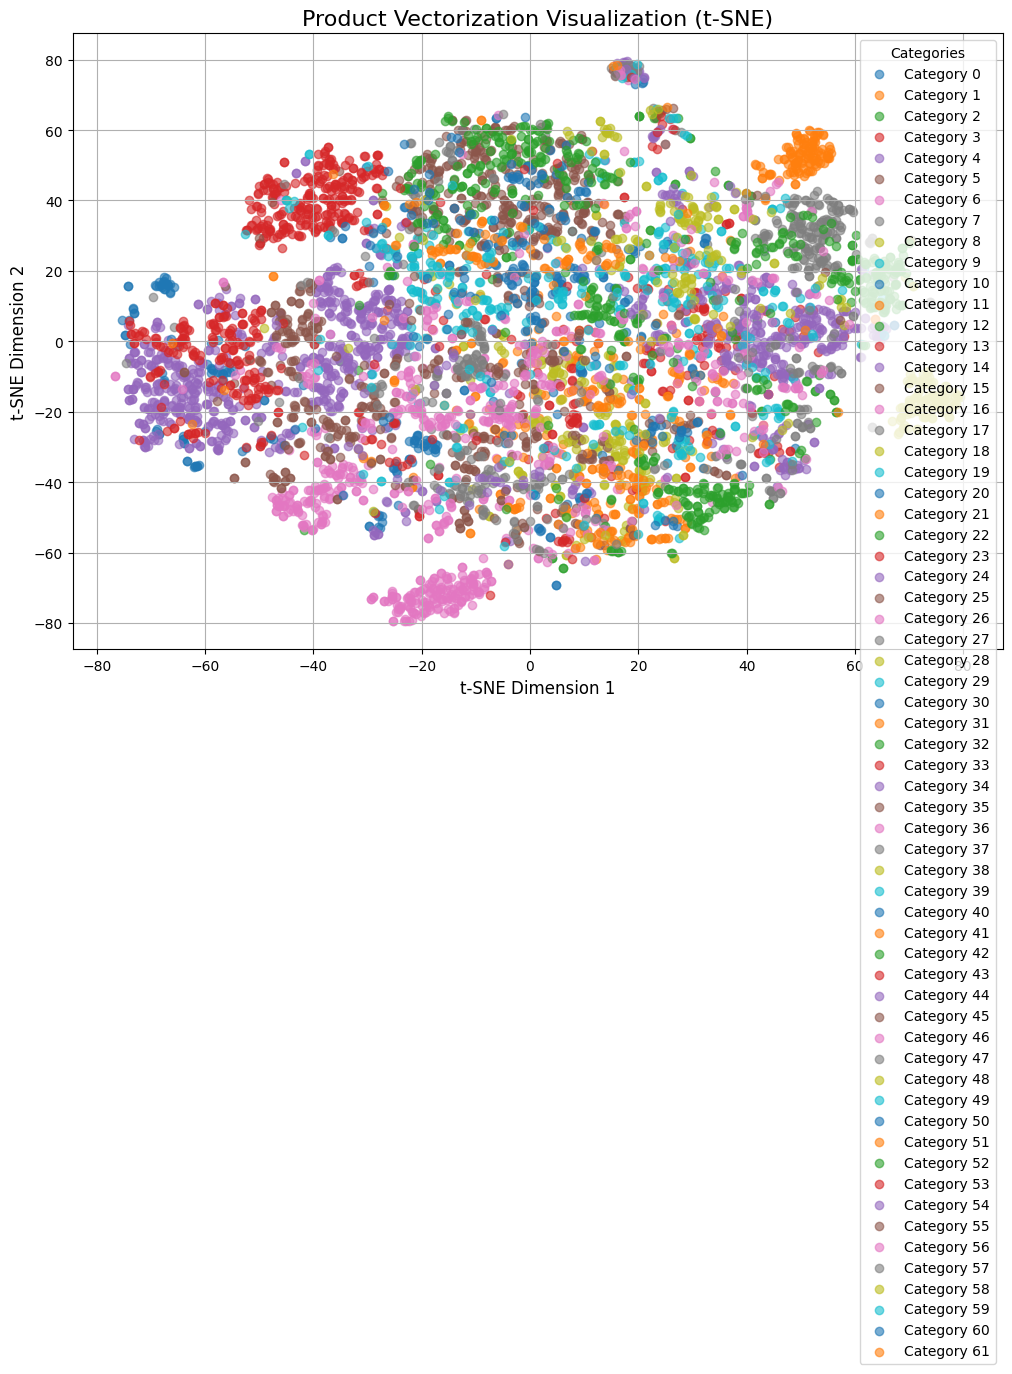

In [5]:
# Fetch data
df = fetch_data()

# Clean and prepare data
inventory_features, product_ids, category_ids, department_ids, num_products, num_categories, num_departments = clean_and_prepare_data(df)

# Train the model
model = ProductVectorizationModel(num_products, num_categories, num_departments)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    latent_vectors = model(inventory_features, product_ids, category_ids, department_ids)
    loss = criterion(latent_vectors.norm(dim=1), torch.ones_like(latent_vectors.norm(dim=1)))
    loss.backward()
    optimizer.step()

# Visualize product vectors
product_mapping = {prod: idx for idx, prod in enumerate(df['article_number'].unique())}
category_mapping = {cat: idx for idx, cat in enumerate(df['category'].unique())}
department_mapping = {dept: idx for idx, dept in enumerate(df['department'].unique())}

visualize_product_vectors(model, df, product_mapping, category_mapping, department_mapping)
